9) Considere o arquivo sorvete.xls com as seguintes variáveis

Temperatura – temperatura no dia

Preço – preço do sorvete

N_turistas – número de turistas que passaram na cidade(em milhares)

Vendas – Vendas de sorvete no dia (em milhares de R$)

Chuva – Choveu no dia? – 0 não 1 sim

Efetue a análise de correlação, seguida de uma regressão linear stepwise para explicar

as vendas em relação às demais variáveis. Analise os resultados



In [8]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [9]:
Caminho = '/Users/fabicampanari/Desktop/1_Exam-Linear Regression/Sorvete.xlsx'
df = pd.read_excel(Caminho)
df.head()

,Temperatura,Preço,N_turistas,Vendas,Chuva
0,27.0,5.0,89.5,90,0
1,24.0,5.0,86.4,85,0
2,30.0,10.0,99.2,107,0
3,24.0,10.0,72.4,71,1
4,16.0,10.0,71.2,65,1


Estatísticas Descritivas:
        Temperatura     Preço  N_turistas      Vendas      Chuva
count    20.000000  20.00000   20.000000   20.000000  20.000000
mean     22.850000   6.81250   78.955000   76.850000   0.700000
std       4.221187   2.48267   10.992556   13.259654   0.470162
min      16.000000   3.75000   52.100000   53.000000   0.000000
25%      19.750000   5.00000   71.175000   66.750000   0.000000
50%      24.000000   6.87500   76.600000   74.000000   1.000000
75%      26.000000  10.00000   88.025000   85.750000   1.000000
max      30.000000  10.00000   99.200000  107.000000   1.000000


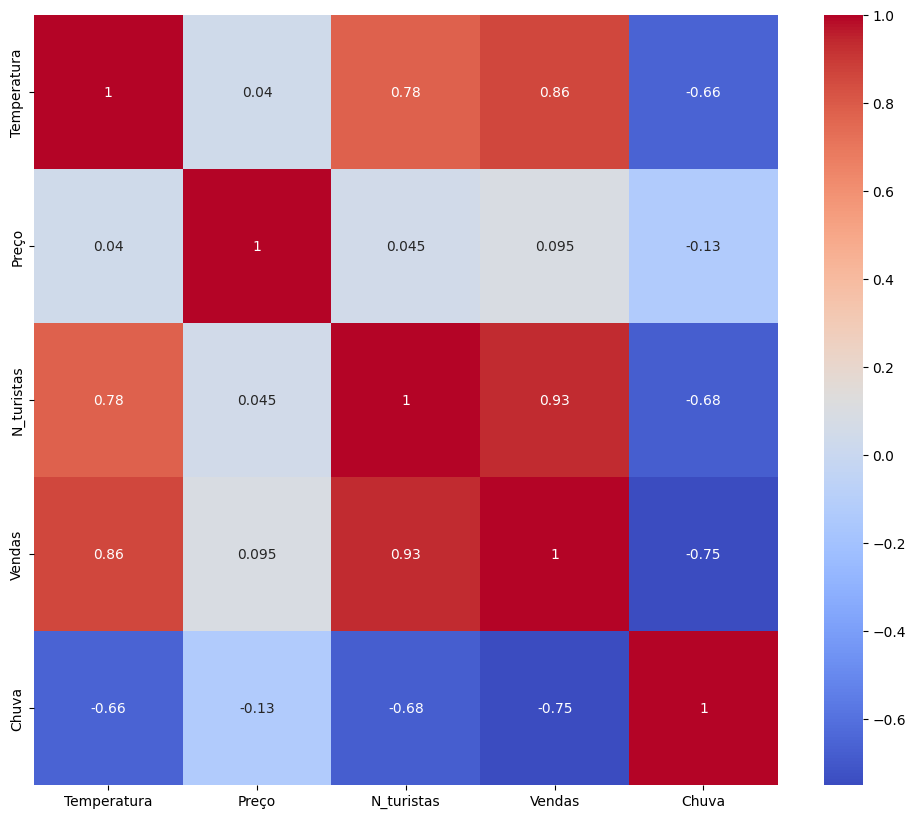

In [10]:
# Análise descritiva
# Estatísticas descritivas
print("Estatísticas Descritivas:\n", df.describe())

# Visualizar a correlação entre as variáveis
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Definir a variável dependente e as variáveis independentes
y = df['Vendas']
X = df[['Temperatura', 'Preço', 'N_turistas', 'Chuva']]

In [11]:
# Método Stepwise para seleção de variáveis
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('Variáveis Selecionadas pelo Método Stepwise:')
print(result)



Add  N_turistas                     with p-value 1.91831e-09
Add  Temperatura                    with p-value 0.00630164
Variáveis Selecionadas pelo Método Stepwise:
['N_turistas', 'Temperatura']


In [12]:
# Ajustar o modelo de regressão linear com as variáveis selecionadas
X_selected = sm.add_constant(df[result])
model_stepwise = sm.OLS(y, X_selected).fit()



In [13]:
# Resumo do modelo stepwise
print(model_stepwise.summary())



                            OLS Regression Results                            
Dep. Variable:                 Vendas   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     95.19
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           5.84e-10
Time:                        11:23:34   Log-Likelihood:                -54.547
No. Observations:                  20   AIC:                             115.1
Df Residuals:                      17   BIC:                             118.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -11.2106      6.679     -1.678      

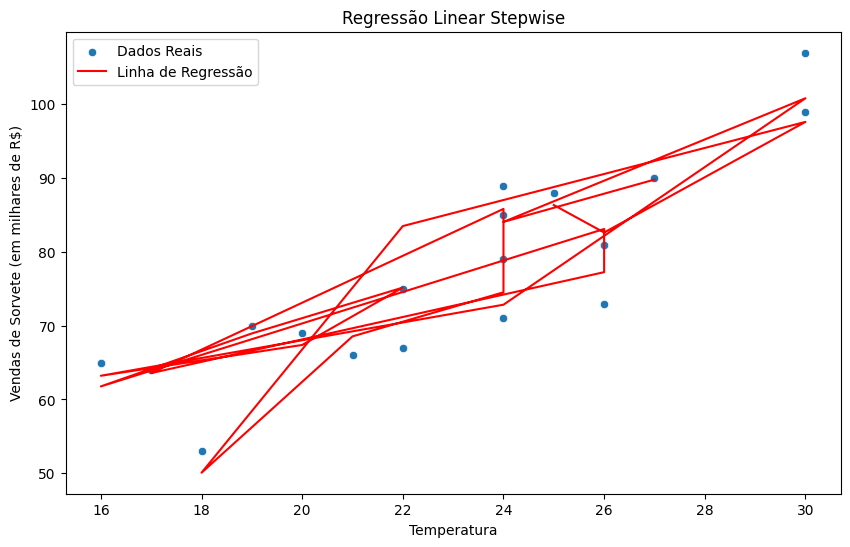

In [14]:
# Visualização dos dados e da linha de regressão
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Temperatura'], y=df['Vendas'], label='Dados Reais')
plt.plot(df['Temperatura'], model_stepwise.predict(X_selected), color='red', label='Linha de Regressão')
plt.xlabel('Temperatura')
plt.ylabel('Vendas de Sorvete (em milhares de R$)')
plt.title('Regressão Linear Stepwise')
plt.legend()
plt.show()

## `Análise e Conclusão`

#### `Estatísticas Descritivas`
As estatísticas descritivas fornecem uma visão geral dos dados, incluindo a média, desvio padrão, valores mínimos e máximos, e quartis. Isso nos ajuda a entender a distribuição dos dados das variáveis envolvidas.

#### `Matriz de Correlação`
A matriz de correlação mostra a relação entre as variáveis Vendas (vendas de sorvete) e as variáveis independentes Temperatura, Preço, N_turistas e Chuva. Valores próximos de 1 ou -1 indicam uma forte correlação positiva ou negativa, respectivamente.

#### `Modelo de Regressão Linear Stepwise`
O método stepwise seleciona as variáveis independentes que têm uma contribuição significativa para o modelo de regressão. O modelo ajustado é exibido com um resumo que inclui coeficientes, erro padrão, valores t, p-valores, R-quadrado, e R-quadrado ajustado.

#### `Visualização`
A visualização mostra a relação entre uma das variáveis independentes (Temperatura) e a variável dependente Vendas, juntamente com a linha de regressão ajustada, permitindo uma análise visual da correlação e da regressão.

#### `Conclusão`
Os resultados indicam quais variáveis independentes têm uma contribuição significativa para prever as vendas de sorvete (Vendas). O modelo de regressão linear stepwise fornece uma forma de prever Vendas com base nas variáveis selecionadas. A visualização confirma que a linha de regressão ajustada se alinha bem com os dados reais, indicando uma boa adequação do modelo.

